# 1. Определение цели

Мы будем предсказывать **долю угарного газа на парковочное место в Москве** на автономный округ. Для этого мы будем использовать данные из портала открытых данных:
- [Парковки такси](https://data.mos.ru/opendata/621)
- [Среднемесячные показатели загрязнения атмосферного воздуха](https://data.mos.ru/opendata/2453/)


In [1]:
import os
from os import path
from tqdm import tqdm
import pandas as pd
import numpy as np
import geopandas as gpd
import requests
import zipfile
import folium
import itertools
from matplotlib import pyplot as plt
import seaborn as sns
from shapely import ops
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from geopy.geocoders import Nominatim
from shapely.geometry import Point
from datetime import datetime
from lxml import etree
import json

#from ..parsers import PollutionDfParser, PollutionMosecomDfParser, TaxiDfParser

In [2]:
!pip install folium

# 2. Сбор и подготовка данных

## 2.1 Подготовка работы с API портала открытых данных

Для доступа к порталу открытых данных нужен токен

In [3]:
with open('api_key.json') as f:
    API_KEY = json.load(f)['api_key']

Определим метод для получения данных о Dataset

In [4]:
def get_dataset_info(dataset_id, api_key):
    base_url = f"https://apidata.mos.ru/v1/datasets/{dataset_id}"
    params = {
        'api_key': api_key
    }

    try:
        response = requests.get(base_url, params=params)
        if response.status_code == 200:
            return response.json()
        else:
            print(f"Ошибка запроса. Статус код: {response.status_code}")
            return None
    except requests.exceptions.RequestException as e:
        print(f"Ошибка запроса: {e}")
        return None

Определим метод для получения актуальной версии и всех доступных версий

In [5]:
def get_dataset_version(dataset_id, api_key):
    base_url = f"https://apidata.mos.ru/v1/datasets/{dataset_id}/version"
    params = {
        'api_key': api_key
    }

    try:
        response = requests.get(base_url, params=params)

        # Проверка статуса ответа
        if response.status_code == 200:
            # Возврат десериализованного JSON объекта
            return response.json()
        else:
            print(f"Ошибка запроса. Статус код: {response.status_code}")
            return None
    except requests.exceptions.RequestException as e:
        print(f"Ошибка запроса: {e}")
        return None

In [6]:
def get_version_history(dataset_id):
    base_url = f"https://data.mos.ru/odata/catalog/versions"
    params = {
        'idDataset': dataset_id
    }

    try:
        response = requests.get(base_url, params=params)

        # Проверка статуса ответа
        if response.status_code == 200:
            # Возврат десериализованного JSON объекта
            return response.json()
        else:
            print(f"Ошибка запроса. Статус код: {response.status_code}")
            return None
    except requests.exceptions.RequestException as e:
        print(f"Ошибка запроса: {e}")
        return None

Определим метод для скачивания Dataset

In [7]:
def get_dataset_rows(dataset_id, version_number, release_number, api_key, skip=0):
    base_url = f"https://apidata.mos.ru/v1/datasets/{dataset_id}/rows"
    params = {
        'versionNumber': version_number,
        'releaseNumber': release_number,
        '$top': 500,
        '$skip': skip,
        'api_key': api_key,
    }

    try:
        response = requests.get(base_url, params=params)
        # Проверка статуса ответа
        if response.status_code == 200:
            # Возврат десериализованного JSON объекта
            return response.json()
        else:
            print(f"Ошибка запроса. Статус код: {response.status_code}")
            return None
    except requests.exceptions.RequestException as e:
        print(f"Ошибка запроса: {e}")
        return None

За 1 раз можно скачать только 500 строк, поэтому нужно делать это через цикл

In [8]:
def download_dataset(dataset_id, api_key, version_number = None, release_number = None):
    info = get_dataset_info(dataset_id, api_key)
    row_count = info['ItemsCount']

    if version_number is None or release_number is None:
        last_version = get_dataset_version(dataset_id, api_key)
        version_number = last_version['VersionNumber']
        release_number = last_version['ReleaseNumber']

    all_rows = []
    for offset in tqdm(range(0, row_count, 500), desc=f'Downloading dataset v{version_number}.{release_number}'):
        raw_rows = get_dataset_rows(
            dataset_id,
            version_number, 
            release_number, 
            api_key=API_KEY,
            skip=offset
        )
        rows = list(map(lambda x: x['Cells'], raw_rows))
        all_rows.extend(rows)
    df = pd.DataFrame(data=all_rows)
    return df

## 2.2 Получение полигонов автономных округов Москвы

Index(['NAME', 'OKATO', 'OKTMO', 'NAME_AO', 'OKATO_AO', 'ABBREV_AO', 'TYPE_MO',
       'geometry'],
      dtype='object')


<Axes: >

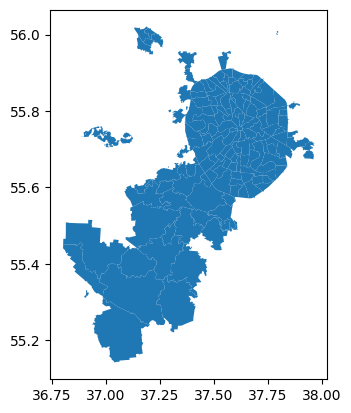

In [9]:
raw_moscow = gpd.read_file('./moscow/mo.shp')
print(raw_moscow.columns)
raw_moscow.plot()

Уберем ненужные колонки

In [10]:
moscow_columns = ['NAME_AO', 'geometry']
raw_moscow = raw_moscow[moscow_columns]

Карта разделена по районам. Объединим их в автономные округи

<Axes: >

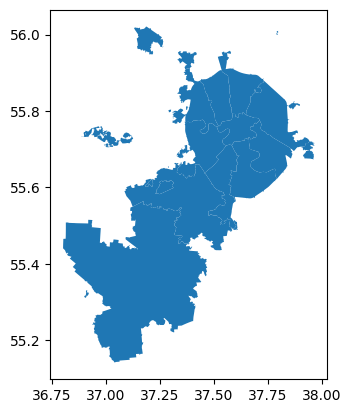

In [11]:
ao_list = list(set(raw_moscow['NAME_AO']))
new_pols = []
for ao in ao_list:
    regs = raw_moscow[raw_moscow['NAME_AO'] == ao]['geometry']
    regs_list = list(regs)

    unary_pol = ops.unary_union(regs_list)
    new_pols.append([ao, unary_pol])

moscow = gpd.GeoDataFrame(
    new_pols, 
    columns=moscow_columns, 
    geometry='geometry', 
    crs=raw_moscow.crs
)
moscow.plot()

У нас есть данные не на все регионы, поэтому уберем ненужные

<Axes: >

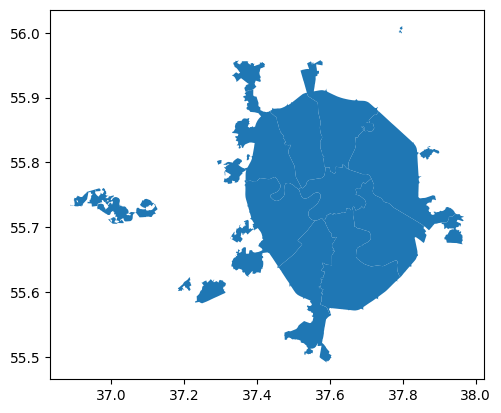

In [12]:
moscow_exclude = ['Троицкий', 'Новомосковский', 'Зеленоградский']
moscow = moscow[~moscow['NAME_AO'].isin(moscow_exclude)]
moscow.plot()

Для совместимости с данными применим `str.capitalize()`, т.к. вдальнейшем будет отличаться регистр

In [13]:
moscow['NAME_AO'] = moscow['NAME_AO'].apply(lambda x: x.capitalize())
ao_list = list(set(moscow['NAME_AO']))
moscow.head(3)

,NAME_AO,geometry
0,Западный,"MULTIPOLYGON (((37.23651 55.59405, 37.23905 55..."
1,Юго-восточный,"MULTIPOLYGON (((37.67457 55.65176, 37.67259 55..."
2,Центральный,"POLYGON ((37.67105 55.75056, 37.67168 55.75036..."


## 2.3 Получение среднемесячных показателей загрязнения атмфосерного воздуха из портала открытых данных

Получим данные о Dataset

In [14]:
POL_DF_FILE_PATH = 'pol.pkl'

if not os.path.exists(POL_DF_FILE_PATH):
    raw_pol_df = download_dataset(2453, API_KEY)
    raw_pol_df.to_pickle(POL_DF_FILE_PATH)
else:
    raw_pol_df = pd.read_pickle(POL_DF_FILE_PATH)
    
raw_pol_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27785 entries, 0 to 27784
Data columns (total 11 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   global_id                        27785 non-null  int64  
 1   ID                               27785 non-null  int64  
 2   Period                           27785 non-null  object 
 3   StationName                      27785 non-null  object 
 4   SurveillanceZoneCharacteristics  27785 non-null  object 
 5   AdmArea                          27785 non-null  object 
 6   District                         27785 non-null  object 
 7   Location                         27785 non-null  object 
 8   Parameter                        27785 non-null  object 
 9   MonthlyAverage                   27785 non-null  float64
 10  MonthlyAveragePDKss              16353 non-null  float64
dtypes: float64(2), int64(2), object(7)
memory usage: 2.3+ MB


In [15]:
raw_pol_df.head(3)

,global_id,ID,Period,StationName,SurveillanceZoneCharacteristics,AdmArea,District,Location,Parameter,MonthlyAverage,MonthlyAveragePDKss
0,272777248,1,02.2016,Лосиный остров,Природные территории,Восточный административный округ,район Метрогородок,"улица Ротерта, дом 4, строение 5",Оксид углерода,0.190,0.06
1,272777249,2,02.2016,Глебовская,Смешанные антропогенные источники загрязнений,Восточный административный округ,район Богородское,"Глебовская улица, дом 3, корпус 1",Оксид углерода,0.320,0.11
2,272777250,3,02.2016,Глебовская,Смешанные антропогенные источники загрязнений,Восточный административный округ,район Богородское,"Глебовская улица, дом 3, корпус 1",Сероводород,0.001,NaN


Уберем ненужные колонки

In [16]:
pol_df_columns = ['StationName', 'Period', 'SurveillanceZoneCharacteristics', 'Location', 'Parameter', 'MonthlyAverage', 'MonthlyAveragePDKss']
pol_df = raw_pol_df[pol_df_columns]
pol_df.columns

Index(['StationName', 'Period', 'SurveillanceZoneCharacteristics', 'Location',
       'Parameter', 'MonthlyAverage', 'MonthlyAveragePDKss'],
      dtype='object')

Преобразуем колонки

In [17]:
pol_df['Period'] = pd.to_datetime(pol_df['Period'], format='%m.%Y')
pol_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27785 entries, 0 to 27784
Data columns (total 7 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   StationName                      27785 non-null  object        
 1   Period                           27785 non-null  datetime64[ns]
 2   SurveillanceZoneCharacteristics  27785 non-null  object        
 3   Location                         27785 non-null  object        
 4   Parameter                        27785 non-null  object        
 5   MonthlyAverage                   27785 non-null  float64       
 6   MonthlyAveragePDKss              16353 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(4)
memory usage: 1.5+ MB


/tmp/ipykernel_32/2958073428.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pol_df['Period'] = pd.to_datetime(pol_df['Period'], format='%m.%Y')


Мы будем рассматривать показания только по угарному газу

In [18]:
allowed_papameters = ['Оксид углерода']
print(f'Кол-во данных до: {len(pol_df)}')
pol_df = pol_df[pol_df['Parameter'].isin(allowed_papameters)]
print(f'Кол-во данных после: {len(pol_df)}')

Кол-во данных до: 27785
Кол-во данных после: 3783


Для разных станций приведены разные предельные допустимые значения (ПДК). Также не для всех веществ вообще представлены ПДК. Унифицируем их для простоты.

In [19]:
def process_pdk(pol_dff):
    parameters_pdks_raw = {}
    raw_parameters_set = set(pol_dff['Parameter'])

    # Соберем показания ПДК для всех вещест
    for param in raw_parameters_set:
        all_pdks = pol_dff[pol_dff.Parameter == param]['MonthlyAveragePDKss']
        min_pdk = pol_dff[pol_dff.Parameter == param]['MonthlyAveragePDKss'].min()
        max_pdk = pol_dff[pol_dff.Parameter == param]['MonthlyAveragePDKss'].max()
        parameters_pdks_raw[param] = (min_pdk, max_pdk)

    # Уберем записи, где ПДК не указан
    def filter_dict(fdict, by_key = lambda x: True, by_value = lambda x: True):
        dict_items = list(fdict.items())
        filtered_items = list(filter(lambda x: by_key(x[0]) and by_value(x[1]), dict_items))
        return dict((k, v) for k, v in filtered_items)
    _parameters_pdks = filter_dict(parameters_pdks_raw, by_value=lambda x: not np.isnan(x[0]) and not np.isnan(x[1]))

    # Унифицируем ПДК
    for key, val in _parameters_pdks.items():
        avg = (val[0] + val[1]) / 2
        if np.isnan(avg):
            avg = 0.1
        _parameters_pdks[key] = avg

    return _parameters_pdks

In [20]:
pdks = process_pdk(pol_df)
pdks

{'Оксид углерода': 0.25}

Для станций не указан автономный округ. Прибегнем к геокодировщику Nominatim

In [21]:
try:
    print(len(cache))
except:
    cache =  {}
    print('Cache initialized')

Cache initialized


In [22]:
geolocator = Nominatim(user_agent="mos-ru-vis-parse")
def geocode_location(raw_loc):
    loc_arr = raw_loc.split(',')
    if 'строение' in loc_arr[-1] or 'корпус' in loc_arr[-1]:
        loc_arr = loc_arr[:-1]
    loc = ''.join(loc_arr)
    loc = loc.replace('дом', '')
    loc = loc.replace('город Москва', '')
    if loc in cache:
        return cache[loc]
    else:
        geo_loc = geolocator.geocode(loc)
        cache[loc] = geo_loc
        
        # if geo_loc is None:
        #     print(f'Could not find location: {loc}')
    return cache[loc]

In [23]:
pol_df['FullLocation'] = 'Москва, ' + pol_df['Location']
pol_df['GeoLocation'] = pol_df['FullLocation'].apply(geocode_location)
print(f"Всего адресов: {len(pol_df['FullLocation'])}")
failed_to_geocode = pol_df[~(pol_df['GeoLocation'].isnull() | pol_df['GeoLocation'].isna())]['GeoLocation']
print(f"Геокодировано адресов: {len(failed_to_geocode)}")

Всего адресов: 3783
Геокодировано адресов: 2534


К сожалению не получится геокодировать все адреса. Уберем те, которые не удалось геокодировать

In [24]:
pol_df = pol_df[~(pol_df['GeoLocation'].isnull() | pol_df['GeoLocation'].isna())]
len(pol_df)

2534

Найдем для каждой станции соответствующий автономный округ

In [25]:
pol_df['Latitude'] = pol_df['GeoLocation'].apply(lambda loc: loc.latitude if loc else None)
pol_df['Longitude'] = pol_df['GeoLocation'].apply(lambda loc: loc.longitude if loc else None)

geometry = [Point(lon, lat) for lon, lat in zip(pol_df['Longitude'], pol_df['Latitude'])]
gdf_points = gpd.GeoDataFrame(pol_df, geometry=geometry, crs=moscow.crs)

pol_df = gpd.sjoin(gdf_points, moscow)
pol_df.head(3)

,StationName,Period,SurveillanceZoneCharacteristics,Location,Parameter,MonthlyAverage,MonthlyAveragePDKss,FullLocation,GeoLocation,Latitude,Longitude,geometry,index_right,NAME_AO
0,Лосиный остров,2016-02-01,Природные территории,"улица Ротерта, дом 4, строение 5",Оксид углерода,0.19,0.06,"Москва, улица Ротерта, дом 4, строение 5","(4, улица Ротерта, Ярославский район, Москва, ...",55.874471,37.728225,POINT (37.72822 55.87447),7,Северо-восточный
97,Полярная,2016-02-01,Смешанные антропогенные источники загрязнений,"Полярная улица, дом 10, строение 1",Оксид углерода,0.50,0.17,"Москва, Полярная улица, дом 10, строение 1","(10, Полярная улица, Заповедный уголок, район ...",55.874719,37.640182,POINT (37.64018 55.87472),7,Северо-восточный
105,Останкино 0,2016-02-01,Жилые территории,"улица Академика Королёва, дом 15А",Оксид углерода,0.32,0.11,"Москва, улица Академика Королёва, дом 15А","(15А, улица Академика Королёва, Останкино, Ост...",55.821106,37.615406,POINT (37.61541 55.82111),7,Северо-восточный


Возьмём среднее от станций, находящихся в одном автономном округе

In [26]:
pol_df = pol_df.groupby(['Period', 'Parameter', 'NAME_AO'])['MonthlyAverage'].mean().reset_index()
pol_df = pol_df.sort_values(by='Period')
pol_df = gpd.GeoDataFrame(pd.merge(pol_df, moscow, on='NAME_AO'), geometry='geometry')
pol_df.head(3)

,Period,Parameter,NAME_AO,MonthlyAverage,geometry
0,2016-02-01,Оксид углерода,Восточный,0.293333,"MULTIPOLYGON (((37.76713 55.73436, 37.76589 55..."
1,2016-03-01,Оксид углерода,Восточный,0.290000,"MULTIPOLYGON (((37.76713 55.73436, 37.76589 55..."
2,2016-04-01,Оксид углерода,Восточный,0.276667,"MULTIPOLYGON (((37.76713 55.73436, 37.76589 55..."


Визуализируем на графике

[]

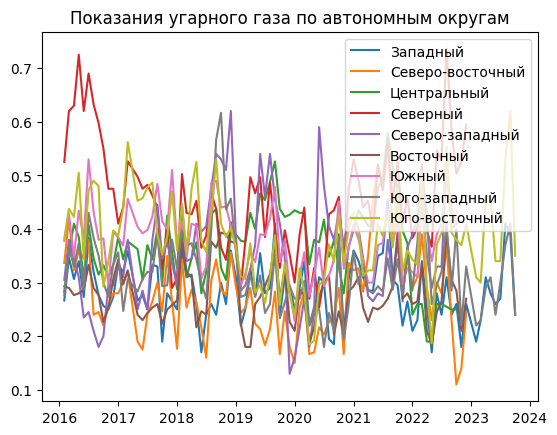

In [27]:
for ao in ao_list:
    df = pol_df[pol_df.NAME_AO == ao]
    plt.plot(df['Period'], df['MonthlyAverage'], label=ao)
plt.title('Показания угарного газа по автономным округам')
plt.legend()
plt.plot()

Визуализируем на карте

In [28]:
import statistics as st
import branca.colormap
import geopandas as gpd
import folium

green_color = '#00FF00'
red_color = '#FF0000'

# ЗДЕСЬ НУЖЕН pdk!!!
pdks = pdks

def style_fn(feature):
    parameter = feature['properties']['Parameter']
    value = feature['properties']['MonthlyAverage']
    cm = branca.colormap.LinearColormap([green_color, red_color], vmin=0, vmax=pdks[parameter])
    color_value = cm(value)
    ss = {
        "fillColor": color_value,
        "fillOpacity": 0.8,
        "weight": 0.8,
        "color": color_value,
    }
    return ss

In [29]:
geojsons = {}

for time in list(set(pol_df['Period'])):
    df = pol_df[pol_df['Period'] == time]
    geojsons[time] = []
    for param in pdks.keys():
        folium_df = df[df.Parameter == param].drop('Period', axis=1)
        if len(folium_df.Parameter) == 0:
            continue
        geojson = folium.GeoJson(
            name=param,
            data=folium_df,
            style_function=style_fn,
            tooltip=folium.features.GeoJsonTooltip(["Parameter", "NAME_AO", "MonthlyAverage"]),
            show=True
        )
        geojsons[time].append(geojson)

In [30]:
keys = sorted(list(geojsons.keys()))
print(f'Доступные даты: {range(len(keys))}')
print(f'От {keys[0]} до {keys[-1]}')

Доступные даты: range(0, 91)
От 2016-02-01 00:00:00 до 2023-10-01 00:00:00


In [31]:
INDEX = 70

m = folium.Map([55.755864, 37.617698], zoom_start=10)
for json in geojsons[keys[INDEX]]:
    json.add_to(m)
    
folium.LayerControl(collapsed=False).add_to(m)
display(m)

## 2.4 Подготовка парсинга сайта mosecom.mos.ru

Как можно было заметить выше - за последний год не на все станции есть показания угарного газа. Мы компенсируем это показаниями станций с другого сайта - вебсайта [мосэкомониторинга](https://mosecom.mos.ru/stations/). 

Веб-сайт не предоставляет публичный API. Однако данные можно спарсить

Получение списка всех доступных станций

In [32]:
def get_stations_url_list():
    ALL_STATIONS_URL = 'https://mosecom.mos.ru/stations/'
    ITEMS_XPATH = '//div[@class="allstan-item"]'
    AO_XPATH = './div[@class="allstan-item-slide"]/h4/text()'
    STATIONS_LIST_XPATH = './div[@class="allstan-item-table"]/div[contains(@class, "allstan-item-row")]/div[@class="row-title"]/a/@href'

    params = {
        'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.9; rv:45.0) Gecko/20100101 Firefox/45.0'
    }

    try:
        response = requests.get(ALL_STATIONS_URL, params=params)

        # Проверка статуса ответа
        if response.status_code == 200:
            parser = etree.HTMLParser()
            tree = etree.fromstring(response.text, parser)
            aos_nodes = tree.xpath(ITEMS_XPATH)
            aos = {}
            for ao_node in aos_nodes:
                ao_name = ao_node.xpath(AO_XPATH)[0]
                stations_urls = ao_node.xpath(STATIONS_LIST_XPATH)
                aos[ao_name] = stations_urls
            return aos

        else:
            print(f"Ошибка запроса. Статус код: {response.status_code}")
            return None
    except requests.exceptions.RequestException as e:
        print(f"Ошибка запроса: {e}")
        return None

Получение данных на станцию

In [33]:
def get_df_for_station(url: str):
    SCRIPT_XPATH = '//script[contains(text(), "AirCharts.init")]/text()'

    params = {
        'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.9; rv:45.0) Gecko/20100101 Firefox/45.0'
    }

    try:
        response = requests.get(url, params=params)

        # Проверка статуса ответа
        if response.status_code == 200:
            parser = etree.HTMLParser()
            tree = etree.fromstring(response.text, parser)
            script_node = tree.xpath(SCRIPT_XPATH)[0]
            start, end = (script_node.find('{'), script_node.rfind('}'))
            script_node = script_node[start:end+1]

            name = str(url).strip('/').split('/')[-1]
            js = json.loads('[' + script_node + ']')

            data = []
            js_data = js[0]['units']['y']
            for key in list(js_data.keys()):
                for param in list(js_data.keys()):
                    arr = js_data[param]['data']
                    data.append([
                       [timestamp, name, param, value] for timestamp, value in arr
                    ])

            merged_data = list(itertools.chain(*data))
            df = pd.DataFrame(merged_data, columns=['Period', 'NAME_AO', 'Parameter', 'MonthlyAverage'])
            df['Period'] = pd.to_datetime(df['Period'], unit='ms')
            return df
        else:
            print(f"Ошибка запроса. Статус код: {response.status_code}")
            return None
    except requests.exceptions.RequestException as e:
        print(f"Ошибка запроса: {e}")
        return None

## 2.5 Получение среднемесячных показателей загрязнения атмфосерного воздуха из портала мосэкомониторинга

In [34]:
POL_DF2_FILE_PATH = './pol2.pkl'
if os.path.exists(POL_DF2_FILE_PATH):
    pol_df2 = pd.read_pickle(POL_DF2_FILE_PATH)
else:
    names_aos = list(aos.keys())
    pol_df2 = []
    for ao in tqdm(names_aos, desc='Пасинг станций автономных округов'):
        for station_url in aos[ao]:
            df = get_df_for_station(station_url)
            
            df['NAME_AO'] = ao.split(' ')[0].capitalize()
            pol_df2.append(df)

    pol_df2 = pd.concat(pol_df2)
    pol_df2.to_pickle(POL_DF2_FILE_PATH)
pol_df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16836 entries, 0 to 107
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Period          16836 non-null  datetime64[ns]
 1   NAME_AO         16836 non-null  object        
 2   Parameter       16836 non-null  object        
 3   MonthlyAverage  16046 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 657.7+ KB


Уберем нулевые показания

In [35]:
pol_df2 = pol_df2[~(pol_df2['MonthlyAverage'].isna() | pol_df2['MonthlyAverage'].isna())]

Проверим, есть ли различия по регионам

In [36]:
set(pol_df.NAME_AO).symmetric_difference(pol_df2.NAME_AO)

{'Зеленоградский', 'Троицкий'}

Оставим только те регионы, на которые есть данные

In [37]:
pol_df2 = pol_df2[~pol_df2.NAME_AO.isin(moscow_exclude)]
set(pol_df.NAME_AO).symmetric_difference(pol_df2.NAME_AO)

set()

In [38]:
pol_df2.head(3)

,Period,NAME_AO,Parameter,MonthlyAverage
0,2023-01-01,Центральный,CO,0.23
1,2023-02-01,Центральный,CO,0.20
2,2023-03-01,Центральный,CO,0.21


Оставим в данных только угарный газ

In [39]:
pol_df2 = pol_df2[pol_df2.Parameter == 'CO']

Вещества в данном датасете имеют другие названия. Сделаем так, чтобы они соответствовали общему набору данных

In [40]:
pol2_to_pol_param_dict = {
    'CO': 'Оксид углерода',
}
pol_df2['Parameter'] = pol_df2['Parameter'].apply(lambda x: pol2_to_pol_param_dict[x])
pol_df2.head(3)

,Period,NAME_AO,Parameter,MonthlyAverage
0,2023-01-01,Центральный,Оксид углерода,0.23
1,2023-02-01,Центральный,Оксид углерода,0.20
2,2023-03-01,Центральный,Оксид углерода,0.21


Сгруппируем данные

In [41]:
pol_df2 = pol_df2 \
    .groupby(['Period', 'Parameter', 'NAME_AO'])['MonthlyAverage'] \
    .mean() \
    .reset_index() \
    .sort_values(by='Period')

Добавим данные о координатах автономных округов

In [42]:
pol_df2 = gpd.GeoDataFrame(pd.merge(pol_df2, moscow, on='NAME_AO'), geometry='geometry')

Подставим полученные данные в общий датасет

In [43]:
min_avaliable = pol_df2['Period'].min()
whole_df = pol_df[pol_df.Period < min_avaliable]
whole_df = pd.concat([whole_df, pol_df2]).sort_values(by='Period').reset_index()
whole_df.head(1)

,index,Period,Parameter,NAME_AO,MonthlyAverage,geometry
0,0,2016-02-01,Оксид углерода,Восточный,0.293333,"MULTIPOLYGON (((37.76713 55.73436, 37.76589 55..."


Визуализируем на графике

[]

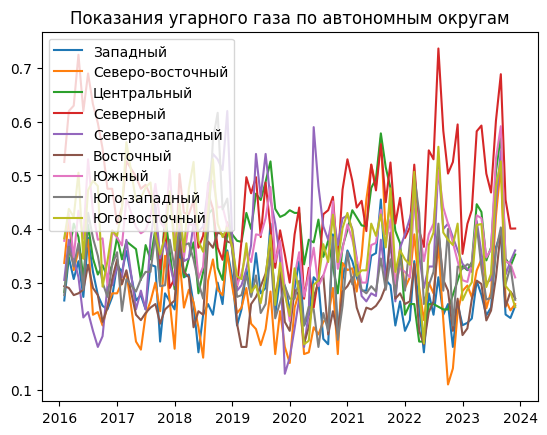

In [44]:
for ao in ao_list:
    df = whole_df[whole_df.NAME_AO == ao]
    plt.plot(df['Period'], df['MonthlyAverage'], label=ao)
plt.title('Показания угарного газа по автономным округам')
plt.legend()
plt.plot()

Визуализируем на карте

In [45]:
import statistics as st
import branca.colormap
import geopandas as gpd
import folium

green_color = '#00FF00'
red_color = '#FF0000'

# ЗДЕСЬ НУЖЕН pdk!!!
pdks = pdks

def style_fn(feature):
    parameter = feature['properties']['Parameter']
    value = feature['properties']['MonthlyAverage']
    cm = branca.colormap.LinearColormap([green_color, red_color], vmin=0, vmax=pdks[parameter])
    color_value = cm(value)
    ss = {
        "fillColor": color_value,
        "fillOpacity": 0.8,
        "weight": 0.8,
        "color": color_value,
    }
    return ss

geojsons = {}

for time in list(set(pol_df['Period'])):
    df = pol_df2[pol_df2['Period'] == time]
    geojsons[time] = []
    for param in pdks.keys():
        folium_df = df[df.Parameter == param].drop('Period', axis=1)
        if len(folium_df.Parameter) == 0:
            continue
        geojson = folium.GeoJson(
            name=param,
            data=folium_df,
            style_function=style_fn,
            tooltip=folium.features.GeoJsonTooltip(["Parameter", "NAME_AO", "MonthlyAverage"]),
            show=True
        )
        geojsons[time].append(geojson)
        
keys = sorted(list(geojsons.keys()))
print(f'Доступные даты: {range(len(keys))}')
print(f'От {keys[0]} до {keys[-1]}')

Доступные даты: range(0, 91)
От 2016-02-01 00:00:00 до 2023-10-01 00:00:00


In [46]:
INDEX = 90
print(keys[INDEX])

m = folium.Map([55.755864, 37.617698], zoom_start=10)
for json in geojsons[keys[INDEX]]:
    json.add_to(m)
    
folium.LayerControl(collapsed=False).add_to(m)
display(m)

2023-10-01 00:00:00


## 2.6 Получение данных такси из портала открытых данных

В данном случае данные доступны только на определенную дату. Нам нужно скачать все версии датасета, чтобы получить данные по парковкам

In [47]:
TAXI_DF_FILE_PATH = 'taxi.pkl'

if not os.path.exists(TAXI_DF_FILE_PATH):
    versions = get_version_history(621)[0]['releases']
    all_taxi_dfs = []
    for version in versions:
        vNum = version['versionNum']
        rNum = version['releaseNum']
        vDate = version['releaseDate']

        date = np.datetime64(datetime.strptime(vDate, "%Y-%m-%d %H:%M:%S")).date()

        raw_taxi_df = download_dataset(
            dataset_id=621, 
            release_number=rNum,
            version_number=vNum,
            api_key=API_KEY)
        raw_taxi_df['Period'] = [date for i in raw_taxi_df.index]
        all_taxi_dfs.append(raw_taxi_df)
    
    raw_taxi_df = pd.concat(all_taxi_dfs)
    raw_taxi_df.to_pickle(TAXI_DF_FILE_PATH)
else:
    raw_taxi_df = pd.read_pickle(TAXI_DF_FILE_PATH)
    
raw_taxi_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17583 entries, 0 to 382
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ID                   17583 non-null  float64       
 1   Name                 17583 non-null  object        
 2   global_id            17583 non-null  float64       
 3   AdmArea              17583 non-null  object        
 4   District             17583 non-null  object        
 5   Address              17583 non-null  object        
 6   LocationDescription  17583 non-null  object        
 7   Longitude_WGS84      17583 non-null  object        
 8   Latitude_WGS84       17583 non-null  object        
 9   CarCapacity          17583 non-null  float64       
 10  Mode                 17583 non-null  object        
 11  geoData              17583 non-null  object        
 12  Period               17583 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(3), obje

Уберем ненужные колонки

In [48]:
taxi_columns = ['AdmArea', 'CarCapacity', 'Period']
taxi_df = raw_taxi_df.sort_values(by='Period').reset_index()[taxi_columns]
taxi_df.head(3)

,AdmArea,CarCapacity,Period
0,Юго-Восточный административный округ,5.0,2020-07-06 12:38:09
1,Центральный административный округ,2.0,2020-07-06 12:38:09
2,Центральный административный округ,4.0,2020-07-06 12:38:09


Просуммируем парковки по автономным округам

In [49]:
taxi_df = taxi_df \
    .groupby(['Period', 'AdmArea'])['CarCapacity'] \
    .sum() \
    .reset_index()

Добавим данные по автономным округам

In [50]:
taxi_df['NAME_AO'] = taxi_df['AdmArea'].apply(lambda x: x.split()[0].capitalize())
taxi_df = taxi_df.drop('AdmArea', axis=1)
taxi_df = gpd.GeoDataFrame(pd.merge(taxi_df, moscow, on='NAME_AO'))
taxi_df.head(1)

,Period,CarCapacity,NAME_AO,geometry
0,2020-07-06 12:38:09,185.0,Восточный,"MULTIPOLYGON (((37.76713 55.73436, 37.76589 55..."


Даты идут вразнобой. Сделаем данные ежемесячными

In [51]:
min_per = taxi_df['Period'].min()
max_per = taxi_df['Period'].max() + pd.DateOffset(months = 1)

min_per = datetime(year = min_per.year, month = min_per.month, day = 1)
max_per = datetime(year = max_per.year, month = max_per.month, day = 1)

date_range = pd.date_range(
    start = min_per,
    end = max_per,
    freq='MS'
)

In [52]:
rows = []

for i in range(len(date_range) - 1):
    date1 = date_range[i]
    date2 = date_range[i + 1]
    df = taxi_df[(taxi_df.Period >= date1) & (taxi_df.Period <= date2)]
    if len(df) == 0:
        continue

    for ao in ao_list:
        ao_df = df[df.NAME_AO == ao.capitalize()]
        if len(ao_df) == 0:
            continue
        row = ao_df.iloc[0]
        row['Period'] = date1
        rows.append(row)

new_taxi_df = gpd.GeoDataFrame(rows, geometry='geometry', crs=taxi_df.crs).reset_index().sort_values(by='Period')
taxi_df = new_taxi_df.copy().reset_index().sort_values(by='Period')

/tmp/ipykernel_32/1733299014.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Period'] = date1
/tmp/ipykernel_32/1733299014.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Period'] = date1
/tmp/ipykernel_32/1733299014.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Period'] = date1
/tmp/ipykernel_32/1733299014.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame


Визуализируем на графике

[]

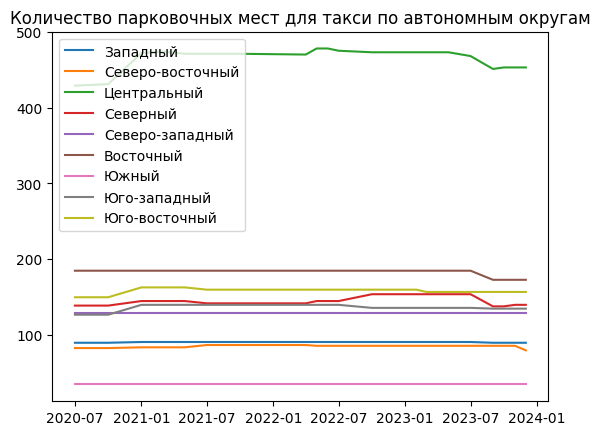

In [53]:
for ao in ao_list:
    df = taxi_df[taxi_df.NAME_AO == ao]
    plt.plot(df['Period'], df['CarCapacity'], label=ao)
plt.title('Количество парковочных мест для такси по автономным округам')
plt.legend()
plt.plot()

Визуализируем на карте

In [54]:
import statistics as st
import branca.colormap
import geopandas as gpd
import folium

max_parking_places = taxi_df['CarCapacity'].max()

green_color = '#00FF00'
red_color = '#FF0000'

def style_fn(feature):
    value = feature['properties']['CarCapacity']
    cm = branca.colormap.LinearColormap([green_color, red_color], vmin=0, vmax=max_parking_places)
    color_value = cm(value)
    ss = {
        "fillColor": color_value,
        "fillOpacity": 0.8,
        "weight": 0.8,
        "color": color_value,
    }
    return ss

In [55]:
geojsons = {}

for time in list(set(taxi_df['Period'])):
    folium_df = taxi_df[taxi_df.Period == time].drop('Period', axis=1)
    geojson = folium.GeoJson(
        name='Парковки',
        data=folium_df,
        style_function=style_fn,
        tooltip=folium.features.GeoJsonTooltip(["CarCapacity", "NAME_AO"]),
        show=True
    )
    geojsons[time] = geojson
    
keys = sorted(list(geojsons.keys()))
print(f'Доступные даты: {range(len(keys))}')
print(f'От {keys[0]} до {keys[-1]}')

Доступные даты: range(0, 21)
От 2020-07-01 00:00:00 до 2023-12-01 00:00:00


In [56]:
INDEX = 15

time = keys[INDEX]
m = folium.Map([55.755864, 37.617698], zoom_start=10)

geojsons[time].add_to(m)
folium.LayerControl(collapsed=True).add_to(m)
m

## 2.7 Введение синтетического признака

Мы введем признак: **Удельный вклад парковочных мест по выбросам угарного газа**

Рассчитывать его будем по формуле:

$$ContributionValue = \frac{MonthlyAverage}{CarCapacity}$$

Индекс рассчитывается для каждого региона отдельно

In [59]:
rows = []

for i in range(len(date_range) - 1):
    date1 = date_range[i]
    date2 = date_range[i + 1]

    date_whole_df = whole_df[(whole_df.Period >= date1) & (whole_df.Period <= date2)]
    date_taxi_df = taxi_df[(taxi_df.Period >= date1) & (taxi_df.Period <= date2)]

    #if len(date_whole_df) == 0 or len(date_taxi_df) == 0:
        #continue

    prev_pol_vals = { key: whole_df[whole_df.NAME_AO == key].iloc[0]['MonthlyAverage'] for key in ao_list }
    prev_taxi_vals = { key: taxi_df[taxi_df.NAME_AO == key].iloc[0]['CarCapacity'] for key in ao_list }
    prev_geo_vals = { key: taxi_df[taxi_df.NAME_AO == key].iloc[0]['geometry'] for key in ao_list }

    for ao in ao_list:
        ao_whole_df = date_whole_df[date_whole_df.NAME_AO == ao.capitalize()]
        ao_taxi_df = date_taxi_df[date_taxi_df.NAME_AO == ao.capitalize()]

        if not (len(ao_whole_df) == 0 or len(ao_taxi_df) == 0):
            whole_value = ao_whole_df.iloc[0]['MonthlyAverage']
            taxi_value = ao_taxi_df.iloc[0]['CarCapacity']

            prev_pol_vals[ao] = whole_value
            prev_taxi_vals[ao] = taxi_value
        else:
            whole_value = prev_pol_vals[ao]
            taxi_value = prev_taxi_vals[ao]
        contrib_value = whole_value / taxi_value
        new_contrib_row = pd.Series()
        new_contrib_row['ContributionValue'] = contrib_value
        new_contrib_row['NAME_AO'] = ao
        new_contrib_row['Period'] = date1
        new_contrib_row['geometry'] = prev_geo_vals[ao]
        rows.append(new_contrib_row)

contrib_df = gpd.GeoDataFrame(rows, geometry='geometry', crs=taxi_df.crs)

[]

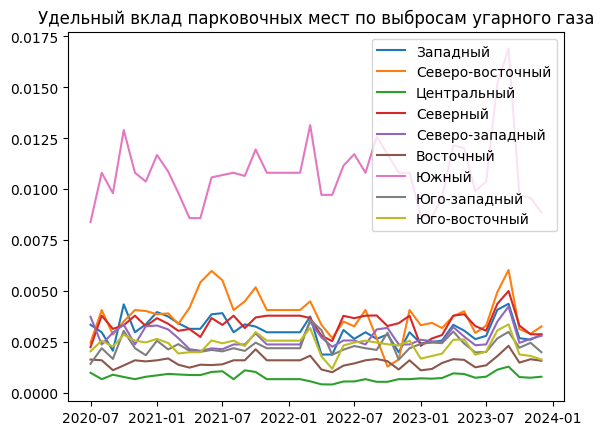

In [60]:
for ao in ao_list:
    df = contrib_df[contrib_df.NAME_AO == ao]
    plt.plot(df['Period'], df['ContributionValue'], label=ao)
plt.title('Удельный вклад парковочных мест по выбросам угарного газа')
plt.legend()
plt.plot()

In [61]:
import statistics as st
import branca.colormap
import geopandas as gpd
import folium

max_contrib = contrib_df['ContributionValue'].max()

green_color = '#00FF00'
red_color = '#FF0000'

def style_fn(feature):
    value = feature['properties']['ContributionValue']
    cm = branca.colormap.LinearColormap([green_color, red_color], vmin=0, vmax=max_contrib)
    color_value = cm(value)
    ss = {
        "fillColor": color_value,
        "fillOpacity": 0.8,
        "weight": 0.8,
        "color": color_value,
    }
    return ss

In [62]:
geojsons = {}

for time in list(set(contrib_df['Period'])):
    folium_df = contrib_df[contrib_df.Period == time].drop('Period', axis=1)
    geojson = folium.GeoJson(
        name='Удельный вклад',
        data=folium_df,
        style_function=style_fn,
        tooltip=folium.features.GeoJsonTooltip(["ContributionValue", "NAME_AO"]),
        show=True
    )
    geojsons[time] = geojson
    
keys = sorted(list(geojsons.keys()))
print(f'Доступные даты: {range(len(keys))}')
print(f'От {keys[0]} до {keys[-1]}')

Доступные даты: range(0, 42)
От 2020-07-01 00:00:00 до 2023-12-01 00:00:00


In [63]:
INDEX = 30

time = keys[INDEX]
m = folium.Map([55.755864, 37.617698], zoom_start=9)

geojsons[time].add_to(m)
folium.LayerControl(collapsed=True).add_to(m)
m

# 3. Тренировка моделей

## 3.1 Выбор моделей

Проверим данные на стационарность

In [64]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

def diki_fuler(monthly_average_series):
    # Проведите тест Дики-Фуллера
    result = adfuller(monthly_average_series)

    # Выведите результат теста
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])

    # Проверьте стационарность на основе p-value
    if result[1] <= 0.05:
        print('Ряд стационарен (reject the null hypothesis)')
    else:
        print('Ряд нестационарен (fail to reject the null hypothesis)')

Данные о загрязнениях

In [65]:
for region in list(set(moscow['NAME_AO'])):
    dfs = whole_df[whole_df.NAME_AO == region]
    print(region)
    if len(dfs['MonthlyAverage']) == 0:
        print('РЕГИОН ПУСТОЙ')
    else:
        diki_fuler(dfs['MonthlyAverage'])

Западный
ADF Statistic: -8.39433950773899
p-value: 2.320804255820473e-13
Critical Values: {'1%': -3.50434289821397, '5%': -2.8938659630479413, '10%': -2.5840147047458037}
Ряд стационарен (reject the null hypothesis)
Северо-восточный
ADF Statistic: -5.079309242367941
p-value: 1.5426047388437427e-05
Critical Values: {'1%': -3.503514579651927, '5%': -2.893507960466837, '10%': -2.583823615311909}
Ряд стационарен (reject the null hypothesis)
Центральный
ADF Statistic: -3.8520417677597574
p-value: 0.0024175564108971925
Critical Values: {'1%': -3.512738056978279, '5%': -2.8974898650628984, '10%': -2.585948732897085}
Ряд стационарен (reject the null hypothesis)
Северный
ADF Statistic: -4.637073978584028
p-value: 0.00011030154419476126
Critical Values: {'1%': -3.502704609582561, '5%': -2.8931578098779522, '10%': -2.583636712914788}
Ряд стационарен (reject the null hypothesis)
Северо-западный
ADF Statistic: -4.854341852809007
p-value: 4.275956392706753e-05
Critical Values: {'1%': -3.505190196159

Данные о такси

In [66]:
for region in list(set(moscow['NAME_AO'])):
    dfs = taxi_df[taxi_df.NAME_AO == region]
    print(region)
    if len(dfs['CarCapacity']) == 0:
        print('РЕГИОН ПУСТОЙ')
    else:
        try: 
            diki_fuler(dfs['CarCapacity'])
        except:
            print('Ряд одинаков')

Западный
ADF Statistic: -1.6641005886756872
p-value: 0.4496973310099292
Critical Values: {'1%': -3.8092091249999998, '5%': -3.0216450000000004, '10%': -2.6507125}
Ряд нестационарен (fail to reject the null hypothesis)
Северо-восточный
ADF Statistic: -1.3793227244586583
p-value: 0.5921479456433969
Critical Values: {'1%': -3.8092091249999998, '5%': -3.0216450000000004, '10%': -2.6507125}
Ряд нестационарен (fail to reject the null hypothesis)
Центральный
ADF Statistic: -2.9559371901837053
p-value: 0.039219265852875766
Critical Values: {'1%': -3.8092091249999998, '5%': -3.0216450000000004, '10%': -2.6507125}
Ряд стационарен (reject the null hypothesis)
Северный
ADF Statistic: -1.8098271492661024
p-value: 0.3755938170023524
Critical Values: {'1%': -4.01203360058309, '5%': -3.1041838775510207, '10%': -2.6909873469387753}
Ряд нестационарен (fail to reject the null hypothesis)
Северо-западный
Ряд одинаков
Восточный
ADF Statistic: -0.4107919181288717
p-value: 0.9082812602591923
Critical Values:

Было принято решение использовать модель SARIMAX. Для каждого отдельного региона будет использоваться 2 отдельных модели, которые будут прогнозировать:
- Показания по угарному газу
- Количество парковочных мест

## 3.2 Разделение выборок на тренировочную и валидационную

In [67]:
def train_test_split_df(df, plot_column):
    split_index = int(0.8 * len(df))

    df_train = df.iloc[:split_index]
    df_test = df.iloc[split_index:]

    for ao in ao_list:
        df = df_train[df_train.NAME_AO == ao]
        plt.plot(df['Period'], df[plot_column], color='blue')

    for ao in ao_list:
        df = df_test[df_test.NAME_AO == ao]
        plt.plot(df['Period'], df[plot_column], color='red')

    plt.title('Разделение на обучающую и тестовую выборки')
    plt.legend()
    plt.plot()

    return (df_train, df_test)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


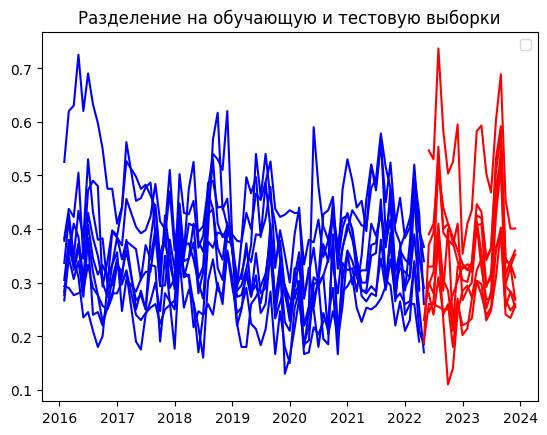

In [68]:
whole_df_train, whole_df_test = train_test_split_df(whole_df, plot_column='MonthlyAverage')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


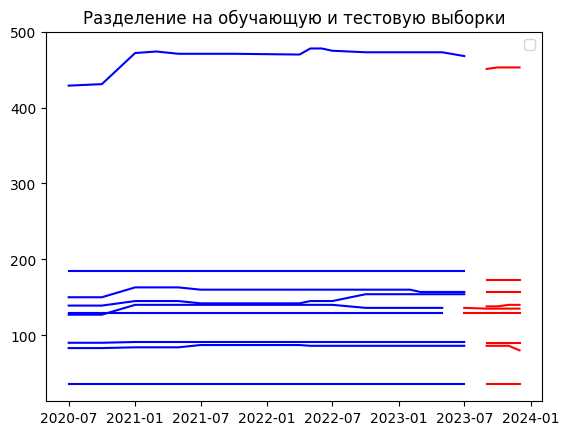

In [69]:
taxi_df_train, taxi_df_test = train_test_split_df(taxi_df, plot_column='CarCapacity')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


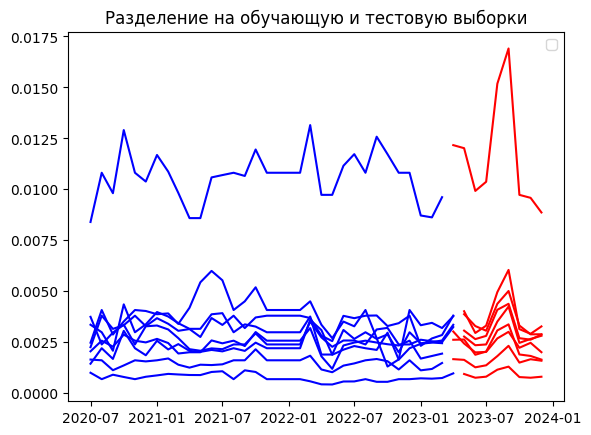

In [70]:
contrib_df_train, contrib_df_test = train_test_split_df(contrib_df, plot_column='ContributionValue')

## 3.3 Обучение моделей

In [71]:
def train_sarimax(ao_df):
    ao_df.set_index('Period', inplace=True)
    ao_df = ao_df.asfreq('MS')
    order = (1, 1, 1)
    seasonal_order = (1, 1, 1, 12)

    model = SARIMAX(ao_df, order=order, seasonal_order=seasonal_order)
    result = model.fit(disp=False)

    return result

In [72]:
def get_prediction_for(test_df, model):
    start = test_df['Period'].min()
    end = test_df['Period'].max()
    predictions = model.get_prediction(start=start, end=end, dynamic=False)
    return predictions.predicted_mean

In [73]:
def plot_results(INDEX, pol_predictions_sarimax, df_train, df_test, plot_column):
    prediction_sarimax = pol_predictions_sarimax[INDEX]
    ao = ao_list[INDEX]

    df_train = df_train[df_train['NAME_AO'] == ao]
    df_test = df_test[df_test['NAME_AO'] == ao]

    # Визуализация предсказаний
    plt.figure(figsize=(10, 6))
    plt.plot(df_train['Period'], df_train[plot_column], label='Train')
    plt.plot(df_test['Period'], df_test[plot_column], label='Test')
    plt.plot(prediction_sarimax, label='Predicted SARIMAX', color='Red')
    plt.title(ao)
    plt.legend()
    plt.show()

### 3.3.1 Данные о выбросах

Данные о выбросах будем предсказывать с помощью SARIMAX

In [74]:
sarimax_pol_models = []
sarimax_pol_predicitons = []

for ao in tqdm(ao_list, desc='Обучение моделей'):
    ao_df = whole_df_train[whole_df_train['NAME_AO'] == ao][['Period', 'MonthlyAverage']].copy()
    result = train_sarimax(ao_df)
    sarimax_pol_models.append(result)
    
sarimax_pol_predicitons = [get_prediction_for(whole_df_test, model) for model in sarimax_pol_models]

Обучение моделей:  22%|██▏       | 2/9 [00:01<00:05,  1.17it/s]/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Обучение моделей:  33%|███▎      | 3/9 [00:02<00:05,  1.16it/s]/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Обучение моделей:  78%|███████▊  | 7/9 [00:06<00:02,  1.00s/it]/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Обучение моделей: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


Выведем предсказания на графике

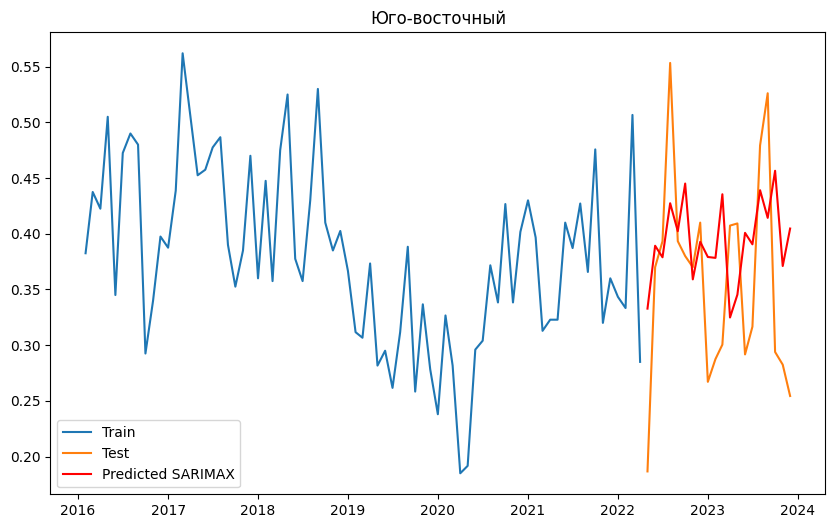

In [75]:
INDEX = 8

plot_results(
    INDEX,
    sarimax_pol_predicitons,
    whole_df_train,
    whole_df_test,
    'MonthlyAverage'
)

Сохраним модели

In [76]:
from pickle import dumps
POL_MODELS_PATH = './pol_models'
if not os.path.exists(POL_MODELS_PATH):
    os.mkdir(POL_MODELS_PATH)

for i in range(len(sarimax_pol_models)):
    ao = ao_list[i]
    name = f'{ao}-pol.pkl'
    sarimax_pol_models[i].save(os.path.join(POL_MODELS_PATH, name))

### 3.3.2 Данные о такси

Данные о выбросах будем предсказывать с помощью SARIMAX

In [77]:
sarimax_taxi_models = []
sarimax_taxi_predicitons = []

for ao in tqdm(ao_list, desc='Обучение моделей'):
    ao_df = taxi_df_train[taxi_df_train['NAME_AO'] == ao][['Period', 'CarCapacity']].copy()
    result = train_sarimax(ao_df)
    sarimax_taxi_models.append(result)
    
sarimax_taxi_predicitons = [get_prediction_for(taxi_df_test, model) for model in sarimax_taxi_models]

Обучение моделей:   0%|          | 0/9 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
Обучение моделей:  11%|█         | 1/9 [00:00<00:04,  1.65it/s]/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/lo

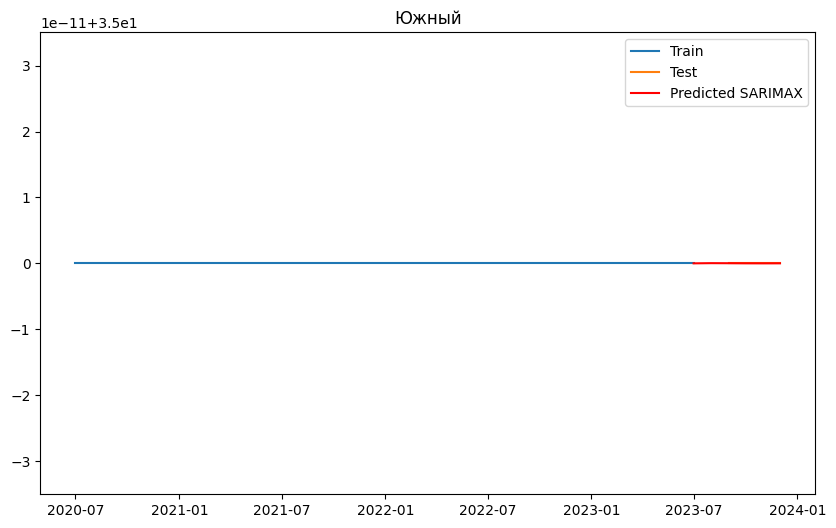

In [78]:
INDEX = 6

plot_results(
    INDEX,
    sarimax_taxi_predicitons,
    taxi_df_train,
    taxi_df_test,
    'CarCapacity'
)

### 3.3.3 Данные об удельном вкладе

Удельный вклад будем предсказывать с помощью модели LSTM

In [360]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

2024-01-11 00:23:23.291781: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /device:GPU:0 with 5082 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:02:00.0, compute capability: 8.6


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 602057036569395729
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 5329846272
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 13710638993259870988
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:02:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

Напишем функцию для обучения модели

In [474]:
def train_model(data, scaler):
    # Нормализуем данные с помощью MinMaxScaler-а
    scaled_data = scaler.transform(data)

    # Создадим наборы данных для обучения модели
    X, y = [], []
    for i in range(len(scaled_data) - 20):
        X.append(scaled_data[i:i+20])
        y.append(scaled_data[i+20])
    X, y = np.array(X), np.array(y)

    # Спроектируем модель
    # Количество выходных нейронов равно количеству значений,
    # которое модель вернет по инференсу
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
    model.add(LSTM(units=50))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    history = model.fit(X, y, epochs=50, verbose=0)
    return model, history

In [475]:
col = contrib_df['ContributionValue']
col = np.array(col).reshape(-1, 1)
scaler = MinMaxScaler()
_ = scaler.fit_transform(col)

Обучим для каждого автономного округа модель, которая будет предсказывать показания удельного вклада

In [481]:
model_name

'./contrib_models/Юго-восточный.keras'

Сохраним модели

In [480]:
CONTRIB_MODELS_PATH = './contrib_models'

if not os.path.exists(CONTRIB_MODELS_PATH):
    os.mkdir(CONTRIB_MODELS_PATH)

ao_models = {}
for ao in tqdm(ao_list, desc='Обучение моделей'):
    data = contrib_df[contrib_df.NAME_AO == ao][['ContributionValue']]
    model, history = train_model(np.array(data), scaler)
    ao_models[ao] = model

    model_name = os.path.join(CONTRIB_MODELS_PATH, f'{ao}.keras')
    model.save(model_name)

Обучение моделей:   0%|          | 0/9 [00:00<?, ?it/s]

Обучение моделей: 100%|██████████| 9/9 [00:42<00:00,  4.78s/it]


Загрузим модели

In [485]:
import keras

In [492]:
CONTRIB_MODELS_PATH = './contrib_models'
ao_models = {}

for ao in tqdm(ao_list, desc='Загрузка моделей'):
    model_name = os.path.join(CONTRIB_MODELS_PATH, f'{ao}.keras')
    model = keras.models.load_model(model_name)
    ao_models[ao] = model

Загрузка моделей: 100%|██████████| 9/9 [00:05<00:00,  1.55it/s]


In [477]:
def get_prediction(data, scaler, model):
    '''
    Ожидает "сырые" данные, т.е. колонку или dataframe с одной колонкой
    '''
    x = data.reshape(-1, 1)
    scaled_x = scaler.transform(x)
    pred = model.predict(scaled_x[np.newaxis], verbose=0)
    unscaled_pred = scaler.inverse_transform(pred)[0]
    return unscaled_pred

In [514]:
get_prediction(np.array(data['ContributionValue']), scaler, model)

array([0.00230193], dtype=float32)

In [478]:
def generate_predictions(data: np.array, count, scaler, model):
    WINDOW_WIDTH = 20

    window = data[:WINDOW_WIDTH]
    all_predictions = []
    for i in range(GEN_COUNT):
        pred = get_prediction(window, scaler, model)
        all_predictions.append(pred[0])
        window = np.append(window[1:], pred[0])
    all_predictions = np.array(all_predictions)
    return all_predictions

In [519]:
inp = np.array(data['ContributionValue'])
preds = generate_predictions(np.array(data['ContributionValue']), 30, scaler, model)

In [521]:
preds

array([0.00234499, 0.00234888, 0.00234911, 0.00234868, 0.00234562,
       0.00234277, 0.00233964, 0.00233572, 0.00233222, 0.00232993,
       0.00232723, 0.00232448, 0.00232032, 0.00231695, 0.00231356,
       0.00231121, 0.00230734, 0.00230508, 0.00230306, 0.00230125],
      dtype=float32)

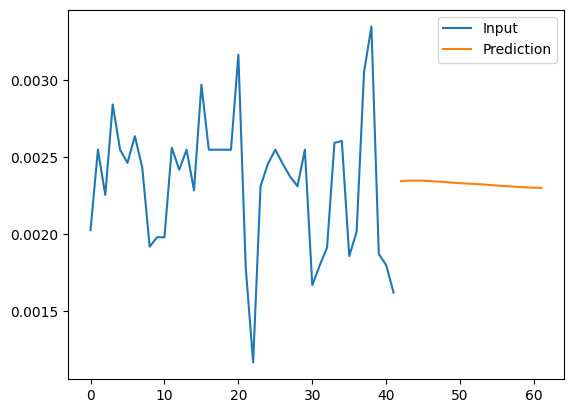

In [520]:
INDEX = 0

plot_arr = np.append(inp, preds)
offset = len(inp)

plt.plot(range(0, offset), inp, label='Input')
plt.plot(range(offset, offset + len(preds)), preds, label='Prediction')
plt.legend()
plt.show()